In [1]:
import os
from glob import glob

from sklearn.covariance import graphical_lasso,shrunk_covariance
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso
from sklearn.covariance import EmpiricalCovariance
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, DBSCAN
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import matplotlib.pyplot as plt

In [39]:
def calculate_volume(A:list[str], adj_mat:pd.DataFrame)->float:
    volume: float = adj_mat.loc[A, :].to_numpy().sum()
    return volume

def calculate_cut(S:list[str], adj_mat:pd.DataFrame)->float:
    # Ensure S is a list or set of nodes
    S = list(S)
    # Complement of S (all nodes not in S)
    all_nodes = set(adj_mat.index)
    S_complement = list(all_nodes - set(S))
    
    # Extract the submatrix corresponding to edges between S and S_complement
    cut_matrix = adj_mat.loc[S, S_complement]
    
    # Sum the weights of the edges in the cut
    cut_value = cut_matrix.to_numpy().sum()
    
    return cut_value

# Calculate the conductance of a node set S, given by the total weight of edges starting in S and ending out of S divided 
# by the minimum of volumes of S and V\S, where the volume of node set A is given by the sum of weights of all edges starting in A
def calculate_conductance(S:list[str], adj_mat: pd.DataFrame)->float:
    # Calculate the volume of S
    vol_S:float = calculate_volume(S, adj_mat)
    
    # Calculate the volume of the complement of S
    all_nodes = set(adj_mat.index)
    S_complement = list(all_nodes - set(S))
    vol_S_complement:float = calculate_volume(S_complement, adj_mat)
    
    # Calculate the cut between S and S_complement
    cut_value = calculate_cut(S, adj_mat)

    # Compute the conductance
    conductance = cut_value / min(vol_S, vol_S_complement)
    return conductance

cluster_palette = ["#1f77b4", "#ff7f0e", "#279e68", "#d62728", "#aa40fc", "#aa40fc", \
                  "#e377c2", "#b5bd61", "#17becf", "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", \
                  "#c5b0d5", "#c49c94", "#f7b6d2", "#dbdb8d", "#9edae5", "#ad494a", "#8c6d31", \
                  "#b4d2b1", "#568f8b", "#1d4a60", "#cd7e59", "#ddb247", "#d15252", \
                  "#264653", "#2a9d8f", "#e9c46a", "#e76f51", "#f4a261", "#ef476f", \
                  "#ffd166","#06d6a0","#118ab2","#073b4c", "#fbf8cc","#fde4cf", \
                  "#ffcfd2","#f1c0e8","#cfbaf0","#a3c4f3","#90dbf4","#8eecf5", \
                  '#8359A3', '#5e503f', '#33CC99', '#F2C649', '#B94E48', '#0095B7', \
                  '#FF681F', '#e0aaff', '#FED85D', '#0a0908', '#C32148', '#98f5e1', \
                  "#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", \
                  "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87", \
                  "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80", \
                  "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100", \
                  "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F", \
                  "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09", \
                  "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66", \
                  "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C", \
                  "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81", \
                  "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00", \
                  "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700", \
                  "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329", \
                  "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C", \
                  "#00B7FF", "#004DFF", "#00FFFF", "#826400", "#580041", "#FF00FF", "#00FF00", "#C500FF", \
                  "#B4FFD7", "#FFCA00", "#969600", "#B4A2FF", "#C20078", "#0000C1", "#FF8B00", "#FFC8FF", \
                  "#666666", "#FF0000", "#CCCCCC", "#009E8F", "#D7A870", "#8200FF", "#960000", "#BBFF00", \
                  "#FFFF00", "#006F00"]

def construct_information_hop_matrix(adj_mat : pd.DataFrame, verbose=False):
    S = adj_mat.columns

    # For information distance calculation, only the absolute values of the edge weights are used
    adj_mat = adj_mat.abs()

    # print("(Non-negative) adjacency matrix")
    # print(adj_mat)

    outdegrees = adj_mat.sum(axis=1)
    indegrees = adj_mat.sum(axis=0)
    
    # Print nodes with outdegree equal to 0
    outdeg_zero_nodes = list(np.where(outdegrees == 0)[0])
    outdeg_zero_node_labels = adj_mat.columns[outdeg_zero_nodes]
    if verbose:
        print(f"Nodes with outdegree 0 are {outdeg_zero_node_labels}")

    # Print nodes with indegree equal to 0
    indeg_zero_nodes = list(np.where(indegrees == 0)[0])
    indeg_zero_node_labels = adj_mat.columns[indeg_zero_nodes]
    if verbose:
        print(f"Nodes with indegree 0 are {indeg_zero_node_labels}")

    S_zero_outdeg_labels = [node for node in S if node in outdeg_zero_node_labels]
    S_zero_indeg_labels = [node for node in S if node in indeg_zero_node_labels]
    if (len(S_zero_outdeg_labels) > 0):
        warnings.warn(f"There are {len(S_zero_outdeg_labels)} zero outdegree nodes in S and they are {S_zero_outdeg_labels}.")
    if (len(S_zero_indeg_labels) > 0):
        warnings.warn(f"There are {len(S_zero_indeg_labels)} zero indegree nodes in S and they are {S_zero_indeg_labels}.")
    S_zero_total_deg_labels = list(set(S_zero_outdeg_labels).intersection(S_zero_indeg_labels))
    if (len(S_zero_total_deg_labels) > 0):
        warnings.warn(f"There are {len(S_zero_total_deg_labels)} nodes in S with a total degree of 0 and they are {S_zero_total_deg_labels}.")

    total_deg_zero_node_labels = set(indeg_zero_node_labels).intersection(set(outdeg_zero_node_labels))
    if verbose:
        print(f"Dropping {len(total_deg_zero_node_labels)} nodes with total degree equal to 0 from the dataframe.")
    adj_mat = adj_mat.drop(total_deg_zero_node_labels, axis=0)
    adj_mat = adj_mat.drop(total_deg_zero_node_labels, axis=1)
    
    #outdegrees = outdegrees[outdegrees != 0]
    outdegrees = adj_mat.sum(axis=1)

    # Normalize each element of the adjacency matrix by the degree of the source node
    with np.errstate(divide='ignore', invalid='ignore'):
        normalized_adj_mat = adj_mat.div(outdegrees, axis=0)
    
    if verbose:
        print("Normalized adjacency matrix")
        print(normalized_adj_mat)

    # Create the information hop matrix
    IHM = pd.DataFrame()

    # Apply the transformation -log(normalized_adj_mat[i,j])
    # Use np.where to handle division by zero and logarithm of zero gracefully
    with np.errstate(divide='ignore', invalid='ignore'):
        IHM = np.abs(-np.log(normalized_adj_mat))

    if verbose:
        print("Information hop distance matrix")
        print(IHM)

    return IHM

In [42]:
construct_information_hop_matrix(diff_df)

GeneID,100130872,79792,253935,8786,390877,59269,105378723,100527960,100189323,105374690,...,100506068,57664,101928295,2217,27180,107985327,102238594,79143,9437,102465482
GeneID,,,,,,,,,,,,,,,,,,,,,
100130872,6.678987,12.808162,8.967425,8.117224,7.511956,7.108604,8.995468,9.752664,7.511956,7.177492,...,6.990266,7.196804,9.954896,7.118662,10.927581,10.927581,10.927581,8.072536,8.219534,10.927581
79792,12.372007,6.242833,6.355205,6.411374,8.597172,7.957216,7.647603,10.429771,8.350312,7.538063,...,7.485313,7.347043,7.291411,7.190097,6.269542,6.269542,6.269542,9.009653,10.688405,6.269542
253935,8.567155,6.391089,6.278717,6.438239,8.038573,7.398384,7.504940,8.038574,8.038573,7.494388,...,7.371399,7.434855,8.347617,7.543900,6.383552,6.383552,6.383552,11.213580,8.297203,6.383552
8786,7.759840,6.490146,6.481126,6.321604,7.524330,7.342515,11.362246,8.728306,9.944699,7.221472,...,7.355435,7.286494,7.473795,7.878874,6.442127,6.442127,6.442127,9.280268,10.203315,6.442127
390877,7.182511,8.703882,8.109398,7.552269,6.349542,6.782190,8.080189,10.476677,7.911727,7.015453,...,7.870107,7.512461,9.417775,7.559638,8.655863,8.655863,8.655863,7.701054,8.655863,8.655863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107985327,10.517846,6.295961,6.374087,6.389776,8.575573,7.958857,8.201368,8.575576,8.575573,7.710482,...,7.415923,7.547698,7.260739,7.417891,6.269253,6.269253,6.269253,9.042542,8.834205,6.269253
102238594,10.517846,6.295961,6.374087,6.389776,8.575573,7.958857,8.201368,8.575576,8.575573,7.710482,...,7.415923,7.547698,7.260739,7.417891,6.269253,6.269253,6.269253,9.042542,8.834205,6.269253
79143,7.445687,8.818959,10.987002,9.010803,7.403651,7.436210,6.736569,6.918143,7.040746,7.910255,...,8.323442,6.673696,7.876552,8.157687,8.825429,8.825429,8.825429,6.052139,6.938361,8.825429


In [ ]:
# Download data from http://www.inbirg.com/disignatlas/home
path = '../data/CTD-ID-fig2/dsa_exp_download/'
diseases = {'DSA05072': 'Ulcerative colitis', 
    'DSA08946': 'Invasive Breast Carcinoma',
    'DSA01344': 'Asthma',
    'DSA08970': 'Lung Adenocarcinoma',
    'DSA08751': 'Dilated Cardiomyopathy',
    'DSA07529': 'Arthritis',
    'DSA07139': 'Psoriasis',
    'DSA09769': 'Chronic Obstructive Pulmonary Disease',
    'DSA00763': 'Type 2 diabetes'
}

# Specify the number of clusters
n_clusters = 40

for disease_id, disease in diseases.items():
    disease_name = disease.replace(' ', '_')
    profile_df = pd.read_csv(f'{path}{disease_id}_profile.csv')
    profile_df.set_index('GeneID', inplace=True)
    profile_df = profile_df.T

    # Scaling
    profile_df = pd.DataFrame(StandardScaler().fit_transform(profile_df), index=profile_df.index, columns=profile_df.columns)

    # Read metadata dataframe
    meta_df = pd.read_csv(f'{path}{disease_id}_meta.csv')
    meta_df.set_index('sample', inplace=True)
    meta_df.loc[profile_df.index, :]

    # Select the top highly variable genes
    gene_variances = profile_df.var()
    highly_variable = gene_variances.nlargest(2000).index
    highly_variable_df = profile_df[highly_variable]

    case_df = highly_variable_df.loc[meta_df['status'] == 'case'].T
    control_df = highly_variable_df.loc[meta_df['status'] == 'control'].T
    highly_variable_df = highly_variable_df.T
    print(case_df.shape, control_df.shape)
    
    # Create graph
    # Disease + control
    cov_case_ctrl = np.cov(highly_variable_df, bias=False)
    try:
        inv_cov_case_ctrl = np.linalg.inv(cov_case_ctrl)
    except np.linalg.LinAlgError:
        print("Covariance matrix is singular, attempting regularized inversion")
        # Regularize with scikit-learn's EmpiricalCovariance if matrix is singular
        cov_estimator = EmpiricalCovariance().fit(cov_case_ctrl)
        inv_cov_case_ctrl = cov_estimator.precision_

    #  control
    cov_ctrl = np.cov(control_df, bias=False)
    try:
        inv_ctrl = np.linalg.inv(cov_ctrl)
    except np.linalg.LinAlgError:
        print("Covariance matrix is singular, attempting regularized inversion")
        # Regularize with scikit-learn's EmpiricalCovariance if matrix is singular
        cov_estimator = EmpiricalCovariance().fit(cov_ctrl)
        inv_ctrl = cov_estimator.precision_
        
    diff_df = cov_case_ctrl - inv_ctrl
    diff_df = np.abs(diff_df)
    diff_df = pd.DataFrame(np.maximum(diff_df, diff_df.T), index=highly_variable_df.index, columns=highly_variable_df.index ) # keep it symetric

    ihm_diff_df = construct_information_hop_matrix(diff_df)
    print(diff_df.shape)
    
    # Perform spectral clustering
    clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed'  # Use 'precomputed' since we are providing an adjacency matrix
    #     assign_labels='kmeans'
    )

    # Fit the model and get cluster labels
    labels = clustering.fit_predict(diff_df)
    
    # The umap projection can not work if there are NaNs, +inf or -inf values or values that don't fit in float32,
    # so we need to perform the appropriate checks before applying umap and, if needed, perform re-scaling!    
    nans = diff_df.isna().sum()  # Check for NaNs
    plus_infs = (diff_df == float('inf')).sum()  # Check for positive infinity
    minus_infs = (diff_df == float('-inf')).sum()  # Check for negative infinity

    # Check for values that are too large or too small to fit into float32
    float32_min = np.finfo(np.float32).min
    float32_max = np.finfo(np.float32).max

    # Check which values exceed the float32 range
    too_large = (diff_df > float32_max) | (diff_df < float32_min)
    
    if any(too_large):
        
        break
    
    # Apply UMAP
    umap_model = umap.UMAP(n_components=2, random_state=42, metric='precomputed')  # For 2D projection
    umap_embedding = umap_model.fit_transform(ihm_diff_df)

    # Step 2: Create a DataFrame with UMAP coordinates and labels
    df_umap = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
    df_umap['label'] = labels

    # Step 3: Plot with Seaborn
    plt.figure(figsize=(10, 8))
    scatter_plot = sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='label', palette=cluster_palette[:n_clusters], s=50)
    plt.title(f'{disease}: UMAP Projection with cluster labels', size=30)
    plt.box(None)
    scatter_plot.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.savefig(f'{path}{disease_name}_exp_umap.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    # Step 4: Plot UMAP per cluster
    nrows = 5
    fig, axs = plt.subplots(nrows, n_clusters//nrows, figsize=(30, 15))
    
    fig.suptitle(f'{disease}: Umap projection per cluster', size=32)
    xmax = df_umap['UMAP1'].max()
    xmin = df_umap['UMAP1'].min()
    ymax = df_umap['UMAP2'].max()
    ymin = df_umap['UMAP2'].min()
    label = 0
    clusters = {}
    conductances = []
    min_cond = 1
    min_cond_node = -1
    for row in range(nrows):
        for col in range(n_clusters//nrows):
            df_part = df_umap[labels==label]
            sns.scatterplot(data=df_part, x='UMAP1', y='UMAP2', color=cluster_palette[label], s=50, ax=axs[row, col])

            axs[row, col].set(yticklabels=[], xticklabels=[])
            axs[row, col].tick_params(bottom=False, left=False)
            axs[row, col].set_xlabel(None)
            axs[row, col].set_ylabel(None)
            axs[row, col].set_xlim(xmin,xmax)
            axs[row, col].set_ylim(ymin,ymax)

            clusters[label] = [highly_variable_df.index[i] for i, value in enumerate(labels) if value == label]
            cond = np.round(calculate_conductance(clusters[label], (diff_df)), 3)
            conductances.append(cond)
            axs[row, col].set_title(f'{label} ({len(df_part)}): {cond}', size=20)
            if (cond < min_cond) and (len(df_part) <= 100):
                min_cond = cond
                min_cond_node = label

            label += 1
            #         sns.despine(bottom=True, left=True, ax=axs[row, col])
    plt.savefig(f'{path}{disease_name}_exp_umap_per_cluster.png', dpi=200, bbox_inches='tight')
    plt.show()
    print(f'Smallest conductance in cluster: {min_cond_node}')

    # Save graph and S
    diff_df = pd.DataFrame(diff_df, columns=case_df.index)
    g_path = f'{path}{disease_name}_exp_adj.csv'
    diff_df.to_csv(g_path, index=False)
    s_df = pd.DataFrame(clusters[min_cond_node], columns=['x'])
    s_path = f'{path}{disease_name}_exp_s.csv'
    s_df.to_csv(s_path, index=False)
    
    command = f"python ../tests/test_gba.py {disease_name} {g_path} {s_path} >> {path}gba2.log"
    os.system(command)

In [216]:
# disease = 'DSA07529'
# profile_df = pd.read_csv(f'../data/GBA2_v5/dsa_exp_download/{disease}_profile.csv')
# profile_df.set_index('GeneID', inplace=True)
# profile_df = profile_df.T

# # Scaling
# profile_df = pd.DataFrame(StandardScaler().fit_transform(profile_df), index=profile_df.index, columns=profile_df.columns)

# # Read metadata dataframe
# meta_df = pd.read_csv(f'../data/GBA2_v5/dsa_exp_download/{disease}_meta.csv')
# meta_df.set_index('sample', inplace=True)
# meta_df.loc[profile_df.index, :]

# # Select the top highly variable genes
# gene_variances = profile_df.var()
# highly_variable = gene_variances.nlargest(2000).index
# highly_variable_df = profile_df[highly_variable]

# case_df = highly_variable_df.loc[meta_df['status'] == 'case'].T
# control_df = highly_variable_df.loc[meta_df['status'] == 'control'].T
# highly_variable_df = highly_variable_df.T
# print(case_df.shape, control_df.shape)

(2000, 150) (2000, 28)


# Create graph

In [217]:
# shrunk_cov = shrunk_covariance(cov_case_sc, shrinkage=0.5) # Set shrinkage closer to 1 for poorly-conditioned data

# Disease + control
cov_case_ctrl = np.cov(highly_variable_df, bias=False)
try:
    inv_cov_case_ctrl = np.linalg.inv(cov_case_ctrl)
except np.linalg.LinAlgError:
    print("Covariance matrix is singular, attempting regularized inversion")
    # Regularize with scikit-learn's EmpiricalCovariance if matrix is singular
    cov_estimator = EmpiricalCovariance().fit(cov_case_ctrl)
    inv_cov_case_ctrl = cov_estimator.precision_
    
#  control
cov_ctrl = np.cov(control_df, bias=False)
try:
    inv_ctrl = np.linalg.inv(cov_ctrl)
except np.linalg.LinAlgError:
    print("Covariance matrix is singular, attempting regularized inversion")
    # Regularize with scikit-learn's EmpiricalCovariance if matrix is singular
    cov_estimator = EmpiricalCovariance().fit(cov_ctrl)
    inv_ctrl = cov_estimator.precision_

Covariance matrix is singular, attempting regularized inversion
Covariance matrix is singular, attempting regularized inversion


In [240]:
diff_df = cov_case_ctrl - inv_ctrl
diff_df = np.abs(diff_df)
diff_df = pd.DataFrame(np.maximum(diff_df, diff_df.T), index=highly_variable_df.index, columns=highly_variable_df.index ) # keep it symetric

diff_df.shape

(2000, 2000)

In [241]:
# perc_value = np.percentile(inv_cov_case, 0)
# inv_cov_case[inv_cov_case < perc_value] = 0
# inv_cov_case = np.nan_to_num(inv_cov_case, nan=0)
# inv_cov_case = np.maximum(inv_cov_case, inv_cov_case.T)  # keep it symetric
# np.fill_diagonal(inv_cov_case, 0)
# inv_cov_case = np.abs(inv_cov_case)
# inv_cov_case = StandardScaler().fit_transform(inv_cov_case)
# inv_cov_case

In [242]:

# Specify the number of clusters
n_clusters = 40

# Perform spectral clustering
clustering = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed'  # Use 'precomputed' since we are providing an adjacency matrix
#     assign_labels='kmeans'
)

# Fit the model and get cluster labels
labels = clustering.fit_predict(diff_df)



print("Cluster labels for each node:", labels)


Cluster labels for each node: [ 3 34 29 ...  0  0  0]


True


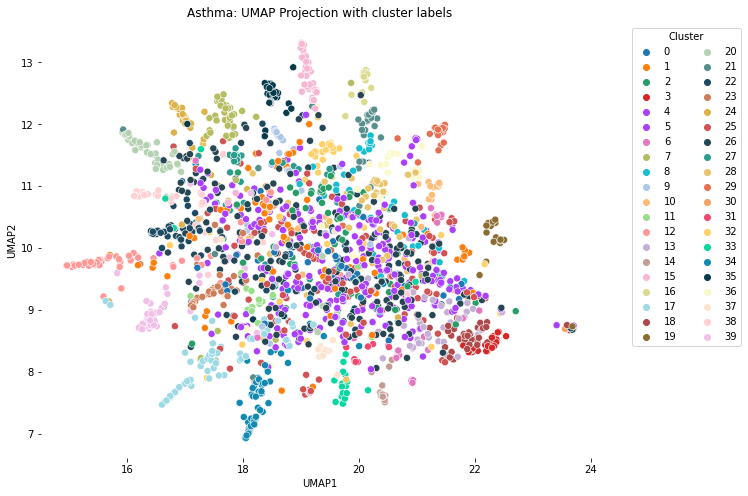

In [44]:
# The umap projection can not work if there are NaNs, +inf or -inf values or values that don't fit in float32,
# so we need to perform the appropriate checks before applying umap and, if needed, perform re-scaling!    
nans = diff_df.isna().sum()  # Check for NaNs
plus_infs = (diff_df == float('inf')).sum()  # Check for positive infinity
minus_infs = (diff_df == float('-inf')).sum()  # Check for negative infinity

# Check for values that are too large or too small to fit into float32
float32_min = np.finfo(np.float32).min
float32_max = np.finfo(np.float32).max

# Check which values exceed the float32 range
too_large = (diff_df > float32_max) | (diff_df < float32_min)

print(any(too_large))

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)  # For 2D projection
umap_embedding = umap_model.fit_transform(diff_df)

# Step 2: Create a DataFrame with UMAP coordinates and labels
df_umap = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
df_umap['label'] = labels

# Step 3: Plot with Seaborn
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='label', palette=cluster_palette[:n_clusters], s=50)
disease_name = disease.replace('_', ' ')
plt.title(f'{disease_name}: UMAP Projection with cluster labels')
plt.box(None)
scatter_plot.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.savefig(f'{disease}_exp_umap.png', dpi=200, bbox_inches='tight')

plt.show()


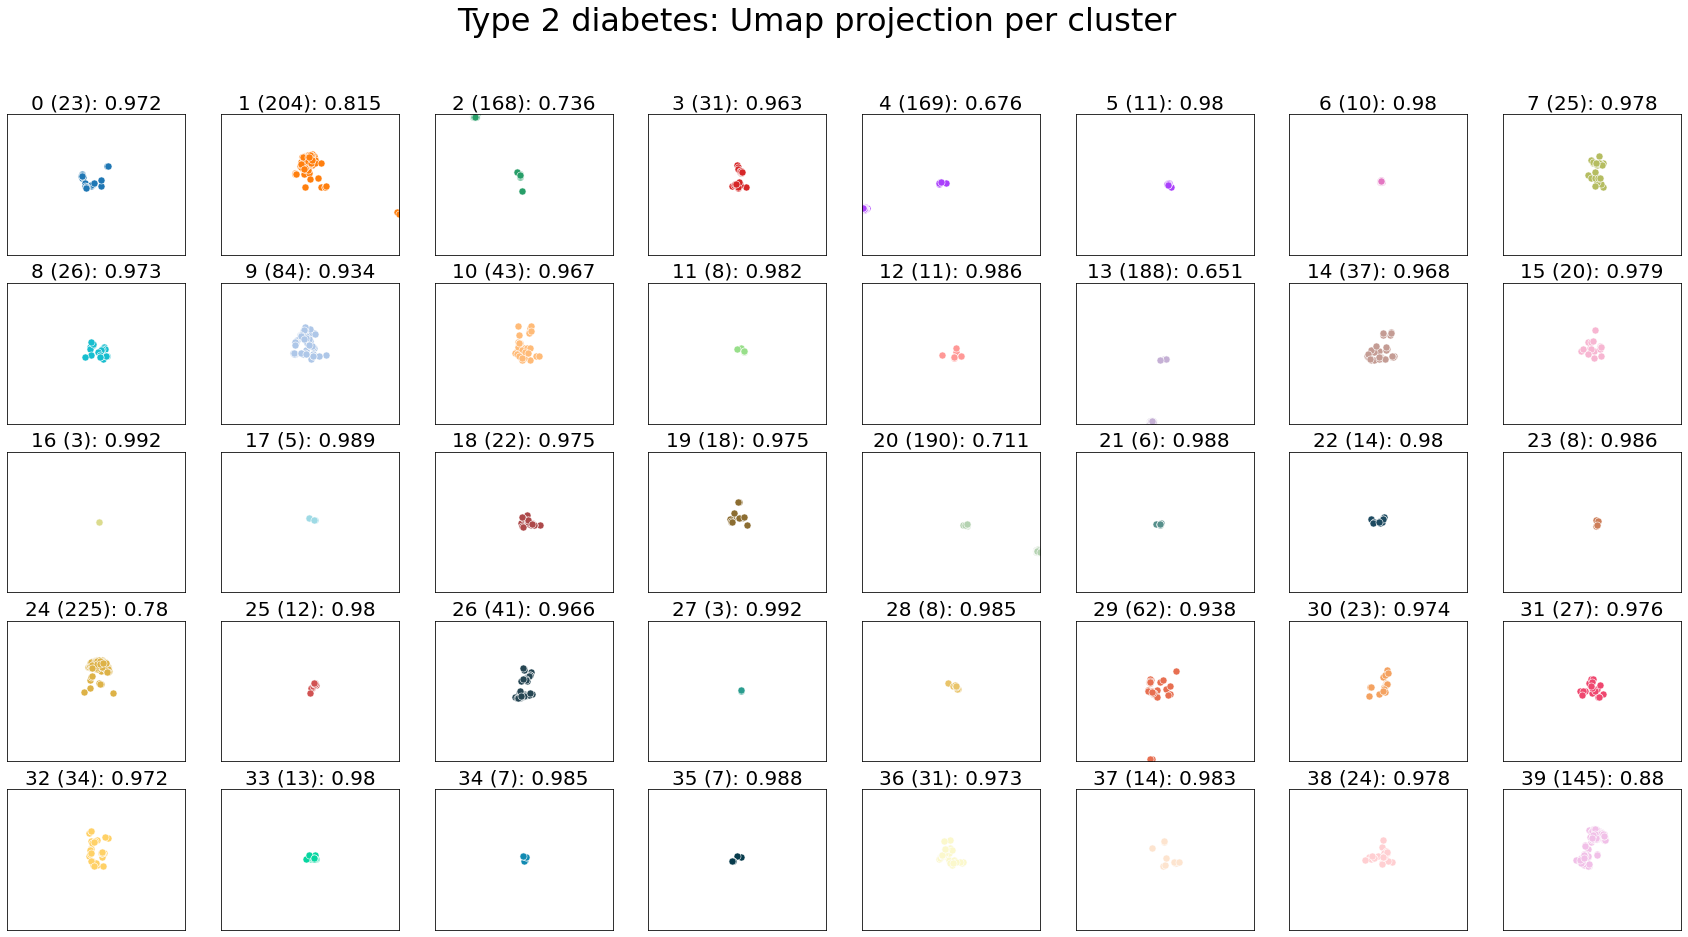

In [273]:
nrows = 5
fig, axs = plt.subplots(nrows, n_clusters//nrows, figsize=(30, 15))
disease_name = disease.replace('_', ' ')
fig.suptitle(f'{disease_name}: Umap projection per cluster', size=32)
xmax = df_umap['UMAP1'].max()
xmin = df_umap['UMAP1'].min()
ymax = df_umap['UMAP2'].max()
ymin = df_umap['UMAP2'].min()
label = 0
clusters = {}
conductances = []
min_cond = 1
min_cond_node = -1
for row in range(nrows):
    for col in range(n_clusters//nrows):
        df_part = df_umap[labels==label]
        sns.scatterplot(data=df_part, x='UMAP1', y='UMAP2', color=cluster_palette[label], s=50, ax=axs[row, col])
        
        
        axs[row, col].set(yticklabels=[], xticklabels=[])
        axs[row, col].tick_params(bottom=False, left=False)
        axs[row, col].set_xlabel(None)
        axs[row, col].set_ylabel(None)
        axs[row, col].set_xlim(xmin,xmax)
        axs[row, col].set_ylim(ymin,ymax)
        
        clusters[label] = [highly_variable_df.index[i] for i, value in enumerate(labels) if value == label]
        cond = np.round(calculate_conductance(clusters[label], (diff_df)), 3)
        conductances.append(cond)
        axs[row, col].set_title(f'{label} ({len(df_part)}): {cond}', size=20)
        if (cond < min_cond) and (len(df_part) <= 100):
            min_cond = cond
            min_cond_node = label

        label += 1
        #         sns.despine(bottom=True, left=True, ax=axs[row, col])

plt.savefig(f'{disease}_exp_umap_per_cluster.png', dpi=200, bbox_inches='tight')

In [259]:
# clusters = {}
# conductances = []
# for cluster in range(n_clusters):
#     clusters[cluster] = [highly_variable_df.index[i] for i, value in enumerate(labels) if value == cluster]
# for cluster in range(n_clusters):
#     cond = calculate_conductance(clusters[cluster], (diff_df))
#     conductances.append(cond)
#     print(cluster, cond)

In [251]:
# Save graph and S
diff_df = pd.DataFrame(diff_df, columns=case_df.index)
diff_df.to_csv('../data/GBA2_v5/dsa_exp_download/arthritis_exp_adj.csv', index=False)
s_df = pd.DataFrame(clusters[min_cond_node], columns=['x'])
s_df.to_csv('../data/GBA2_v5/dsa_exp_download/arthritis_exp_s.csv', index=False)

# Visualize results from 9 diseases

In [2]:
algo_paths = sorted(glob("../results/9_diseases/*"))
all_dfs = pd.DataFrame()
for algo_path in algo_paths:
    filenames = sorted(glob(f"{algo_path}/benchmark_results_*.csv"))
    
    for fname in filenames:
        disease = os.path.basename(fname).replace('benchmark_results_', '').replace('.csv','').replace('_', '\n')
        algo = os.path.basename(algo_path)
        df = pd.read_csv(fname)
        df['disease'] = disease
        df['algorithm'] = algo
        all_dfs = pd.concat([all_dfs, df])
all_dfs

,test_name,ndgc,time,split_name,ranks,disease,algorithm
0,Arthritis_42_radial_min,0.987671,1.040053,generated_42,"0,1,2,3,4,7",Arthritis,ID-GBA
1,Arthritis_42_boundary_min,0.681339,1.093436,generated_42,"1,2,5,9,12,24",Arthritis,ID-GBA
2,Arthritis_45_radial_min,1.000000,0.948012,generated_45,"0,1,2,3,4,5",Arthritis,ID-GBA
3,Arthritis_45_boundary_min,0.858655,1.087566,generated_45,"0,1,4,8,10,16",Arthritis,ID-GBA
4,Arthritis_55_radial_min,1.000000,0.931252,generated_55,"0,1,2,3,4,5",Arthritis,ID-GBA
...,...,...,...,...,...,...,...
5,rwr_ulcerative_colitis_20_rwr,0.264515,2.446618,generated_20,"57,143,295,534,1015,1131,1337,1699,1739,1742,1...",Ulcerative\ncolitis,RWR
6,rwr_ulcerative_colitis_40_rwr,0.266739,2.907518,generated_40,"56,124,264,643,755,1035,1235,1602,1636,1673,18...",Ulcerative\ncolitis,RWR
7,rwr_ulcerative_colitis_18_rwr,0.272295,2.895230,generated_18,"54,58,178,372,1296,1444,1517,1563,1730,1746,17...",Ulcerative\ncolitis,RWR
8,rwr_ulcerative_colitis_22_rwr,0.303561,2.565011,generated_22,"54,56,57,59,217,279,463,1184,1409,1537,1663,18...",Ulcerative\ncolitis,RWR


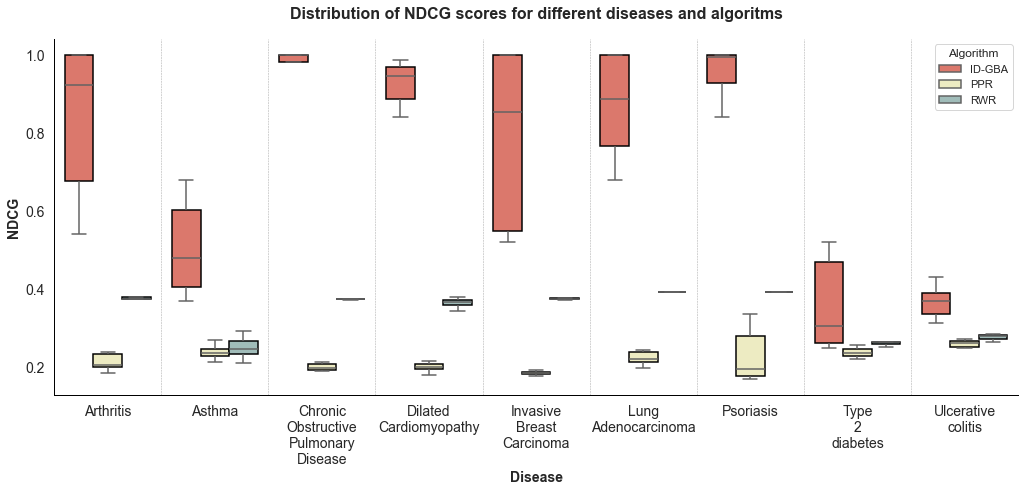

In [15]:
# Conductance values
conductances = {'Arthritis': 0.708, 'Asthma': 0.894, 'Chronic\nObstructive\nPulmonary\nDisease': 0.735,
       'Dilated\nCardiomyopathy': 0.802, 'Invasive\nBreast\nCarcinoma': 0.77,
       'Lung\nAdenocarcinoma': 0.679, 'Psoriasis': 0.756, 'Type\n2\ndiabetes': 0.62,
       'Ulcerative\ncolitis': 0.869}
show_diseases = list(conductances.keys())
conductances = {k: v for k, v in conductances.items() if k in show_diseases}
subset_df = all_dfs[all_dfs['disease'].isin(show_diseases)]
subset_df.rename(columns={'algorithm': 'Algorithm'}, inplace=True)

# Set the figure size and style for Nature-like aesthetics
sns.set(style="white", context="notebook", font="Arial", rc={"axes.edgecolor": "black", "axes.linewidth": 1})

plt.figure(figsize=(len(show_diseases) * 1.6, 7))

# Custom colors for the hue
hue_colors = ['#ed6a5a', '#f4f1bb', '#9bc1bc']

# Create the boxplot with black borders and custom colors
boxplot = sns.boxplot(data=subset_df, x='disease', y='ndgc',
                      hue='Algorithm',  # Different colors for each algorithm
                      palette=hue_colors,  # Custom colors
                      showfliers=False,
                      color='white',  # White fill
                      linewidth=1.5)  # Border width

# Add black borders manually for all boxes
for patch in boxplot.patches:
    patch.set_edgecolor('black')  # Set border color to black
    patch.set_linewidth(1.5)      # Set border width

# Add light vertical lines to separate diseases
for i in range(len(show_diseases) - 1):
    plt.axvline(i + 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Beautify the axes labels and title
plt.xlabel('Disease', fontsize=14, fontweight='bold', fontname='Arial')
plt.ylabel('NDCG', fontsize=14, fontweight='bold', fontname='Arial')
plt.title('Distribution of NDCG scores for different diseases and algoritms', fontsize=16, fontweight='bold', fontname='Arial', pad=20)

# Remove unnecessary spines for a clean look
sns.despine(top=True, right=True, left=False, bottom=False)

# Add conductance values above each box at y=1.01
# for i, (disease, cond) in enumerate(conductances.items()):
#     plt.text(i, 1.01, f'{cond:.3f}', ha='center', va='bottom', fontsize=13, fontname='Arial')

# Adjust tick label size and rotation for clarity
# plt.xticks(fontsize=14, fontname='Arial', rotation=45, ha='right')
plt.yticks(fontsize=14, fontname='Arial')

# Adjust x-tick labels for better alignment
plt.xticks(
    ticks=range(len(show_diseases)),  # Explicitly set ticks for the diseases
    labels=show_diseases,  # Use the disease names as labels
    fontsize=14,  # Adjust font size
    fontname='Arial',  # Set the font
    rotation=0,  # Keep labels upright since they contain newline characters
    ha='center',  # Center-align the labels under the corresponding group
)


# Save and show the plot
plt.savefig('ndcg_9_diseases_boxplot.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


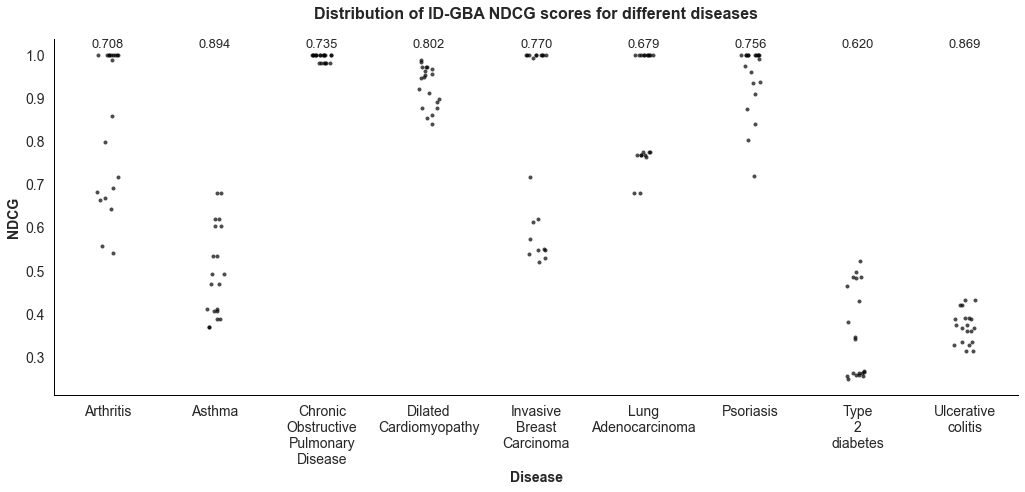

In [17]:
subset_df = all_dfs[all_dfs['algorithm'].isin(['ID-GBA'])]
subset_df = subset_df[subset_df['disease'].isin(show_diseases)]


# Set the figure size and style for Nature-like aesthetics
sns.set(style="white", context="notebook", font="Arial", rc={"axes.edgecolor": "black", "axes.linewidth": 1})

plt.figure(figsize=(len(show_diseases) * 1.6, 7))

# Add light vertical lines to separate diseases
# for i in range(len(show_diseases) - 1):
#     plt.axvline(i + 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Beautify the axes labels and title
plt.xlabel('Disease', fontsize=14, fontweight='bold', fontname='Arial')
plt.ylabel('NDCG', fontsize=14, fontweight='bold', fontname='Arial')
plt.title('Distribution of ID-GBA NDCG scores for different diseases', fontsize=16, fontweight='bold', fontname='Arial', pad=20)

# Remove unnecessary spines for a clean look
sns.despine(top=True, right=True, left=False, bottom=False)

# Add data points with a jittered stripplot for better visibility
sns.stripplot(data=subset_df, x='disease', y='ndgc',
              color='black', size=4, jitter=True, alpha=0.7)

# Add conductance values above each box at y=1.01
for i, (disease, cond) in enumerate(conductances.items()):
    plt.text(i, 1.01, f'{cond:.3f}', ha='center', va='bottom', fontsize=13, fontname='Arial')

plt.yticks(fontsize=14, fontname='Arial')

# Adjust x-tick labels for better alignment
plt.xticks(
    ticks=range(len(show_diseases)),  # Explicitly set ticks for the diseases
    labels=show_diseases,  # Use the disease names as labels
    fontsize=14,  # Adjust font size
    fontname='Arial',  # Set the font
    rotation=0,  # Keep labels upright since they contain newline characters
    ha='center',  # Center-align the labels under the corresponding group
)


# Save and show the plot
plt.savefig('ndcg_9_diseases_idgba.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
